In [20]:
"""
Inference Script
"""
import json
import os
import torch
import tqdm
from shutil import copyfile
from baal.active import FileDataset, ActiveLearningDataset

# Detectron imports
from detectron2.engine import launch
from detectron2.data import build_detection_test_loader, MetadataCatalog

# Project imports
import core.datasets.metadata as metadata

from core.setup import setup_config, setup_arg_parser
from offline_evaluation import compute_average_precision, compute_probabilistic_metrics, compute_calibration_errors
from probabilistic_inference.probabilistic_inference import build_predictor
from probabilistic_inference.inference_utils import instances_to_json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [21]:
arg_parser = setup_arg_parser()
args = arg_parser.parse_args("")
# Support single gpu inference only.
args.num_gpus = 1
args.dataset_dir = '/public-dataset/BDD/bdd100k'
args.test_dataset = 'bdd_val'
args.config_file = '/home/richard.tanai/cvpr2/pod_compare/src/configs/BDD-Detection/retinanet/retinanet_R_50_FPN_1x_reg_cls_var_dropout.yaml'
args.inference_config = '/home/richard.tanai/cvpr2/pod_compare/src/configs/Inference/bayes_od_mc_dropout.yaml'
print("Command Line Args:", args)

Command Line Args: Namespace(config_file='/home/richard.tanai/cvpr2/pod_compare/src/configs/BDD-Detection/retinanet/retinanet_R_50_FPN_1x_reg_cls_var_dropout.yaml', dataset_dir='/public-dataset/BDD/bdd100k', dist_url='tcp://127.0.0.1:50162', eval_only=False, inference_config='/home/richard.tanai/cvpr2/pod_compare/src/configs/Inference/bayes_od_mc_dropout.yaml', iou_correct=0.7, iou_min=0.1, machine_rank=0, min_allowed_score=0.0, num_gpus=1, num_machines=1, opts=[], random_seed=0, resume=False, test_dataset='bdd_val')


In [22]:
global result_list

In [23]:
cfg = setup_config(args, random_seed=args.random_seed, is_testing=True)

# Make sure only 1 data point is processed at a time. This simulates
# deployment.
cfg.defrost()
cfg.DATALOADER.NUM_WORKERS = 32
cfg.SOLVER.IMS_PER_BATCH = 1

cfg.MODEL.DEVICE = device.type

# Set up number of cpu threads
torch.set_num_threads(cfg.DATALOADER.NUM_WORKERS)

# Create inference output directory and copy inference config file to keep
# track of experimental settings
inference_output_dir = os.path.join(
    cfg['OUTPUT_DIR'],
    'inference',
    args.test_dataset,
    os.path.split(args.inference_config)[-1][:-5])
os.makedirs(inference_output_dir, exist_ok=True)
copyfile(args.inference_config, os.path.join(
    inference_output_dir, os.path.split(args.inference_config)[-1]))

# Get category mapping dictionary:
train_thing_dataset_id_to_contiguous_id = MetadataCatalog.get(
    cfg.DATASETS.TRAIN[0]).thing_dataset_id_to_contiguous_id
test_thing_dataset_id_to_contiguous_id = MetadataCatalog.get(
    args.test_dataset).thing_dataset_id_to_contiguous_id

# If both dicts are equal or if we are performing out of distribution
# detection, just flip the test dict.
if (train_thing_dataset_id_to_contiguous_id == test_thing_dataset_id_to_contiguous_id) or (
        cfg.DATASETS.TRAIN[0] == 'coco_not_in_voc_2017_train'):
    cat_mapping_dict = dict(
        (v, k) for k, v in test_thing_dataset_id_to_contiguous_id.items())
else:
    # If not equal, two situations: 1) BDD to KITTI and 2) COCO to PASCAL
    cat_mapping_dict = dict(
        (v, k) for k, v in test_thing_dataset_id_to_contiguous_id.items())
    if 'voc' in args.test_dataset and 'coco' in cfg.DATASETS.TRAIN[0]:
        dataset_mapping_dict = dict(
            (v, k) for k, v in metadata.COCO_TO_VOC_CONTIGUOUS_ID.items())
    elif 'kitti' in args.test_dataset and 'bdd' in cfg.DATASETS.TRAIN[0]:
        dataset_mapping_dict = dict(
            (v, k) for k, v in metadata.BDD_TO_KITTI_CONTIGUOUS_ID.items())
    else:
        ValueError(
            'Cannot generate category mapping dictionary. Please check if training and inference datasets are compatible.')
    cat_mapping_dict = dict(
        (dataset_mapping_dict[k], v) for k, v in cat_mapping_dict.items())

# Build predictor
predictor = build_predictor(cfg)
test_data_loader = build_detection_test_loader(cfg, dataset_name=args.test_dataset)


final_output_list = []
if not args.eval_only:
    with torch.no_grad():
        with tqdm.tqdm(total=len(test_data_loader)) as pbar:
            for idx, input_im in enumerate(test_data_loader):
                #print(input_im.size)
                outputs = predictor(input_im)

                final_output_list.extend(
                    instances_to_json(
                        outputs,
                        input_im[0]['image_id'],
                        cat_mapping_dict))
                pbar.update(1)
                result_list = outputs
                break

    with open(os.path.join(inference_output_dir, 'coco_instances_results.json'), 'w') as fp:
        json.dump(final_output_list, fp, indent=4,
                  separators=(',', ': '))

#compute_average_precision.main(args, cfg)
#compute_probabilistic_metrics.main(args, cfg)
#compute_calibration_errors.main(args, cfg)

WARNING [01/24 21:35:43 fvcore.common.config]: Loading config /home/richard.tanai/cvpr2/pod_compare/src/configs/BDD-Detection/retinanet/../../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
WARNING [01/24 21:35:43 d2.config.compat]: Config '/home/richard.tanai/cvpr2/pod_compare/src/configs/Inference/bayes_od_mc_dropout.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[01/24 21:35:43 detectron2]: Rank of current process: 0. World size: 1
[01/24 21:35:43 detectron2]: Environment info:
----------------------  ----------------------------------------------------------------------
sys.platform            linux
Python                  3.8.5 (default, Sep  4 2020, 07:30:14) [GCC 7.3.0]
numpy                   1.19.5
detectron2              0.3 @/opt/anaconda3/envs/pod/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 10.2
detectron2 arch flags   3.7, 5.0, 5.2, 6.0

[01/24 21:35:43 detectron2]: Full config saved to /home/richard.tanai/cvpr2/pod_compare/data/BDD-Detection/retinanet/retinanet_R_50_FPN_1x_reg_cls_var_dropout/random_seed_0/config.yaml


AssertionError: Dataset 'bdd_train' is already registered!

In [24]:
result_list.pred_boxes_covariance.size()

torch.Size([93, 4, 4])

In [25]:
result_list

Instances(num_instances=93, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[ 790.5698,  357.9676,  900.1068,  427.5728],
        [   0.0000,  336.4445,   52.7929,  402.2242],
        [ 250.7696,  343.7397,  349.7650,  396.0991],
        [1202.5040,  410.6304, 1280.0000,  528.3322],
        [ 748.3016,  358.0167,  812.4692,  410.9435],
        [ 597.1636,  352.4769,  635.0413,  384.2360],
        [  45.9713,  345.7466,  129.6922,  399.8853],
        [ 879.2574,  372.8017,  957.2290,  446.2677],
        [ 935.2418,  332.7353, 1209.2759,  483.8764],
        [ 728.4554,  363.2631,  760.5477,  401.7483],
        [ 682.6030,  356.7921,  721.8698,  390.7504],
        [ 702.1861,  362.4811,  738.5490,  395.5399],
        [ 201.8044,  337.7635,  281.8328,  386.8047],
        [ 582.6869,  355.3024,  602.0551,  376.9820],
        [ 839.1143,  365.4892,  938.9673,  439.0980],
        [ 650.1685,  349.9309,  667.3258,  387.6530],
        [ 446.0694,  352.1874,  480.0779,  374

In [26]:
res_img = predictor.visualize_inference(input_im, outputs)

In [27]:
from matplotlib import pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

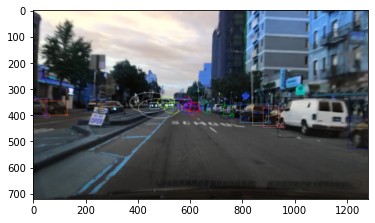

In [28]:
plt.imshow(res_img)
plt.show

In [29]:
next(iter(test_data_loader))[0]

{'file_name': '/public-dataset/BDD/bdd100k/images/100k/val/b1c66a42-6f7d68ca.jpg',
 'height': 720,
 'width': 1280,
 'image_id': 0,
 'image': tensor([[[255, 255, 255,  ...,  56,  53,  51],
          [251, 254, 255,  ...,  55,  52,  50],
          [226, 240, 250,  ...,  54,  51,  49],
          ...,
          [ 48,  48,  48,  ...,  27,  27,  27],
          [ 47,  47,  47,  ...,  25,  25,  25],
          [ 47,  47,  47,  ...,  25,  25,  25]],
 
         [[255, 255, 254,  ...,  88,  85,  83],
          [249, 252, 254,  ...,  87,  84,  82],
          [223, 238, 248,  ...,  86,  83,  81],
          ...,
          [ 57,  57,  57,  ...,  22,  22,  22],
          [ 56,  56,  56,  ...,  20,  20,  20],
          [ 56,  56,  56,  ...,  20,  20,  20]],
 
         [[225, 220, 216,  ..., 123, 120, 118],
          [215, 217, 219,  ..., 122, 119, 117],
          [191, 206, 216,  ..., 121, 118, 116],
          ...,
          [ 60,  60,  60,  ...,  19,  19,  19],
          [ 59,  59,  59,  ...,  17,  17,

TypeError: Invalid shape (3, 750, 1333) for image data

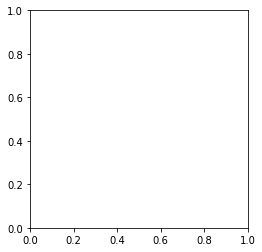

In [30]:
raw_image = next(iter(test_data_loader))[0]['image']
plt.imshow(raw_image)
plt.show

In [10]:
len(test_data_loader)

10000

In [ ]:
test_data_loader.

In [31]:
active_learning_ds = ActiveLearningDataset(test_data_loader)

In [37]:
pool = active_learning_ds

In [33]:
active_learning_ds.n_unlabelled

10000

In [34]:
active_learning_ds.label_randomly(10)

In [38]:
next(iter(pool))[0]

TypeError: 'DataLoader' object is not subscriptable